<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/transformation_index_for_2007_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformative Flows Project (2007-2022)**
**Author:** Marcia R. Ferreira (Complexity Science Hub Vienna & TU Wien)
- **Inputs:** 

1.   CWTS SQL Server [dimensions_2022jun]:


      *   Exported File:
      *   Exported File:


2.   CWTS Publication-level classification system: Meso-fields level [dimensions_2022jun_classification]
3.   Dimension reduction-based clustering: Laplacian matrix contructed from meso-field level topic matrix and second eigenvector of the matrix
4.   Dimensions database on BigQuery


- **Outputs:**

### Initialization and drivers

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Fri Apr 14 11:34:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
#!pip install pynput
#pip install plotly==5.4.0
!pip install patool

# main libraries
import psutil
import humanize
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import torch
import nltk
import GPUtil as GPU

# plotting
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Google big query
from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=8146559a5c5d949458edfd0cf86bec58f66f4cbdd71fd25a9e215fad178efb85
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Provide your credentials to the runtime
#from google.colab import auth
#auth.authenticate_user()
#print('Authenticated')

# declare your project 
#project_id = "cshdimensionstest"

### Data imports

In [ ]:
""" NOT RUN
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1wCFzWEAwBqH47qGQG1_-G6wPgrrs03A6'
print(id) # Verify that you have everything

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('second_eigenvector_clustering.csv')  
clusters = pd.read_csv('second_eigenvector_clustering.csv', sep=",", index_col=0) # Dataset is now stored in a Pandas Dataframe

print(clusters.head(10))
print("The data types are as follows:\n", clusters.dtypes)
print("The type of object is:\n", type(clusters))
"""

In [ ]:
""" NOT RUN
# unzip the files exported from SQL Server
#!unzip "/content/drive/My Drive/TRANSFORMATION/data_export.zip"
#!unzip "/content/drive/My Drive/TRANSFORMATION/data_export.zip" > /dev/null
"""

In [ ]:
!ls "/content/drive/My Drive"

In [ ]:
import patoolib
import tempfile
import os

# Path of the zip file in Google Drive
zip_path = "/content/drive/My Drive/TRANSFORMATION/data_export.zip"

# Name of the CSV file(s) inside the zip
csv_file_names = [  "spectral_meso_clusters.csv"
                  , "for_division_labels.csv"
                  , "grid_ranks.csv"
                  , "trajectories_au_fourfive_skill.csv"
                  , "trajectories_au_morethanfive_skill.csv"
                  , "trajectories_au_single_skill.csv"
                  , "trajectories_au_twothree_skill.csv"]

# Separator character to use in the CSV files
separator = ";"

# Extract the zip file to a temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    patoolib.extract_archive(zip_path, outdir=tmpdir)
    
    # Load each CSV file into its own dataframe
    dfs = []
    for csv_file_name in csv_file_names:
        csv_file_path = os.path.join(tmpdir, csv_file_name)
        try:
            df = pd.read_csv(csv_file_path, sep=separator, encoding='utf-8', header= None, decimal=".")
            dfs.append(df)
        except pd.errors.ParserError:
            print(f"Error loading {csv_file_name}: Skipping...")

################################################################################

# Print the first few rows of each dataframe
for i, df in enumerate(dfs):
    print(f"Dataframe {i}:")
    print(df.head(2))
print("###########################################")

################################################################################

# extract the datasets and store them into a pandas dataframe
spectral_meso_clusters = dfs[0]
for_division_labels = dfs[1]
grid_ranks = dfs[2]
trajectories_au_fourfive_skill = dfs[3]
trajectories_au_morethanfive_skill = dfs[4]
trajectories_au_single_skill = dfs[5]
trajectories_au_twothree_skill = dfs[6]

################################################################################

print(type(for_division_labels))
print("###########################################")

patool: Extracting /content/drive/My Drive/TRANSFORMATION/data_export.zip ...
patool: running /usr/bin/7z x -o/tmp/tmp_35rpnjh -- "/content/drive/My Drive/TRANSFORMATION/data_export.zip"
patool: ... /content/drive/My Drive/TRANSFORMATION/data_export.zip extracted to `/tmp/tmp_35rpnjh'.
Dataframe 0:
          0                   1                 2         3         4   \
0  row_index  second_eigenvector  original_indices  cluster2  cluster3   
1          0  -0,657980785697483               128         0         0   

         5         6          7            8       9   \
0  cluster4  cluster5  cluster10  cluster_id2  n_pubs   
1         0         0          0          128   99353   

                                                  10  \
0                                             labels   
1  inhaler - dry powder inhaler - inhaler devices...   

                                                  11  
0                                            sources  
1  International Journal o

## Preprocessing

In [ ]:
# Use the first row as the header
spectral_meso_clusters.columns = spectral_meso_clusters.iloc[0]
for_division_labels.columns = for_division_labels.iloc[0]
grid_ranks.columns = grid_ranks.iloc[0]

# Remove the first row (which is now the header)
spectral_meso_clusters = spectral_meso_clusters[1:]
for_division_labels = for_division_labels[1:]
grid_ranks = grid_ranks[1:]

print(spectral_meso_clusters.head())
print(for_division_labels.head())
print(grid_ranks.head())
print("###########################################")

def convert_to_float(val):
    if isinstance(val, str) and val.replace('.', '', 1).isdigit():
        return float(val.replace(',', '.'))
    return val

# Apply the function to all elements of the dataframe
grid_ranks = grid_ranks.applymap(convert_to_float)
spectral_meso_clusters = spectral_meso_clusters.applymap(convert_to_float)

print(grid_ranks.dtypes)
print(spectral_meso_clusters.dtypes)
print("###########################################")


from pandas.core.dtypes.dtypes import dtypes
from numpy.core.multiarray import dtype

headers = ['researcher_id', 'grid_id', 'start', 'end', 'Lenght', 'for_division_id', 'meso_field', 'spectral_cluster_id', 'concatenated_fields', 'year', 'n_pubs']

# set the new column names using the list
trajectories_au_morethanfive_skill.columns = headers
trajectories_au_fourfive_skill.columns = headers
trajectories_au_single_skill.columns = headers
trajectories_au_twothree_skill.columns = headers

# print the updated column names
print(trajectories_au_morethanfive_skill.columns)
print(trajectories_au_morethanfive_skill.dtypes)
print("###########################################")

#print(trajectories_au_morethanfive_skill.describe())

0 row_index   second_eigenvector original_indices cluster2 cluster3 cluster4  \
1         0   -0,657980785697483              128        0        0        0   
2         9  -0,0796790037139393              109        4        3        2   
3         6  -0,0866583191228655              146        3        2        1   
4         7  -0,0835526247765448              120        3        2        1   
5         8  -0,0832388670665863              247        4        2        2   

0 cluster5 cluster10 cluster_id2  n_pubs  \
1        0         0         128   99353   
2        1         0         109  106502   
3        1         0         146   91599   
4        1         0         120  102555   
5        1         0         247   65569   

0                                             labels  \
1  inhaler - dry powder inhaler - inhaler devices...   
2  CRT response - CRT device - CRT implantation -...   
3  chiral selector - electrochromatography - plat...   
4  household air pollution - c

In [ ]:
# lets select one for_division_id for now based on the distribution
dist_au_morethanfive_skill = trajectories_au_morethanfive_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_morethanfive_skill = dist_au_morethanfive_skill.groupby('for_division_id').size()

dist_au_fourfive_skill = trajectories_au_fourfive_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_fourfive_skill = dist_au_fourfive_skill.groupby('for_division_id').size()

dist_au_single_skill = trajectories_au_single_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_single_skill = dist_au_single_skill.groupby('for_division_id').size()

dist_au_twothree_skill = trajectories_au_twothree_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_twothree_skill = dist_au_twothree_skill.groupby('for_division_id').size()

In [ ]:
print(counts_morethanfive_skill.sort_values(ascending=False)) # 11
print("#######################################################")
print(counts_fourfive_skill.sort_values(ascending=False)) # 11
print("#######################################################")
print(counts_single_skill.sort_values(ascending=False)) # 9
print("#######################################################")
print(counts_twothree_skill.sort_values(ascending=False)) # 11
print("#######################################################")
print(for_division_labels.sort_values(by = 'for_division_id', ascending=True))

# let's focus on these fields for now
# 11  Medical and Health Sciences --> this script
# 9 Engineering
# 3 Chemical Sciences
# 14 Economics

for_division_id
11    1324980
6      921424
9      788474
3      679351
8      443037
2      422497
10     415103
17     381265
1      319644
5      227942
7      218717
16     163051
4      150015
13     123619
14     121460
15     101627
12      72367
20      51688
21      35669
18      32379
22      28000
19      14716
dtype: int64
#######################################################
for_division_id
11    733497
9     458397
6     450952
3     341837
8     223051
2     202948
17    153643
10    153628
1     149136
5     115981
7     107983
4      88649
16     84704
14     57804
15     56841
13     54123
12     31978
20     26792
21     18864
18     14645
22     14013
19      6625
dtype: int64
#######################################################
for_division_id
9     427405
11    377123
6     261334
3     248461
2     215793
8     164735
1     143401
10     86397
4      81158
17     79467
7      61211
5      58160
16     38247
15     32571
14     29101
13     23939
20     19130

## FOR = 11 | Medical and Health Sciences

In [ ]:
def calculate_org_sequence(df):
    # add a filter based on the value of for_division_id
    for_division_id_filter = (df['for_division_id'] == 11)

    # select the desired columns and drop duplicates
    df = df[['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'start', 'end']][for_division_id_filter].drop_duplicates().reset_index(drop=True)
    
    # concatenate start, end, and for_division_id columns
    df['concatenated'] = df['start'].astype(str) + '_' + df['end'].astype(str)
    
    # calculate the org_sequence using rank() method that considers concatenated column
    df['org_sequence'] = df.groupby('researcher_id')['concatenated'].rank(method='dense')
    
    # drop the concatenated column
    df = df.drop('concatenated', axis=1)
    
    # return the researcher_id, grid_id, for_division_id, and org_sequence columns
    return df[['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'org_sequence']]

################################################################################

def process_dataframe(df, org_seq_df):
    # merge the dataframes on researcher_id and grid_id
    merged_df = pd.merge(df, org_seq_df, on=['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id'], how='left')
    merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_y')]
    merged_df = merged_df.rename(columns=lambda x: x[:-2] if x.endswith('_x') else x)

    # concatenate two columns
    merged_df['concatenated_2'] = merged_df['for_division_id'].astype(str) + ' - ' + merged_df['spectral_cluster_id'].astype(str)

    # select and aggregate columns
    selected_cols = ['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'concatenated_2', 'org_sequence', 'n_pubs']
    selected_df = merged_df[selected_cols].drop_duplicates().reset_index(drop=True)
    aggregated_df = selected_df.groupby(['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'concatenated_2','org_sequence']).sum().reset_index()

    return aggregated_df

################################################################################

sq_1_skill_df = process_dataframe(trajectories_au_single_skill, calculate_org_sequence(trajectories_au_single_skill))
sq_2_3_skill_df = process_dataframe(trajectories_au_twothree_skill, calculate_org_sequence(trajectories_au_twothree_skill))
sq_4_5_skill_df = process_dataframe(trajectories_au_fourfive_skill, calculate_org_sequence(trajectories_au_fourfive_skill))
sq_5_or_more_skill_df = process_dataframe(trajectories_au_morethanfive_skill, calculate_org_sequence(trajectories_au_morethanfive_skill))

################################################################################

print(sq_1_skill_df.head())
print(len(sq_1_skill_df))
print(len(trajectories_au_single_skill))

        researcher_id        grid_id  for_division_id  spectral_cluster_id  \
0  ur.010000007232.43    grid.5596.f               11                   81   
1   ur.01000001217.11  grid.32224.35               11                   77   
2   ur.01000001415.60  grid.427788.6               11                   25   
3  ur.010000022373.01  grid.411154.4               11                   76   
4   ur.01000002646.33    grid.9668.1               11                    0   

  concatenated_2  org_sequence  n_pubs  
0        11 - 81           1.0      10  
1        11 - 77           1.0       1  
2        11 - 25           1.0       1  
3        11 - 76           1.0       1  
4         11 - 0           1.0       1  
415699
5522947


**Looks good!**

In [ ]:
#df_test = sq_2_3_skill_df[sq_2_3_skill_df["researcher_id"] == 'ur.010000002457.43']
#df_test = df_test.drop('concatenated_2', 'for_division_id')

In [ ]:
# we compute the cosine similarity for field 11 only
sq_5_or_more_skill_df.head(100).sort_values(by = ['researcher_id', 'org_sequence'], ascending = True)

,researcher_id,grid_id,for_division_id,spectral_cluster_id,concatenated_2,org_sequence,n_pubs
0,ur.01000000010.53,grid.461843.c,11,5,11 - 5,1.0,1
1,ur.01000000010.53,grid.461843.c,11,6,11 - 6,1.0,1
2,ur.01000000010.53,grid.461843.c,11,8,11 - 8,1.0,4
3,ur.01000000010.53,grid.461843.c,11,29,11 - 29,1.0,1
4,ur.01000000010.53,grid.461843.c,11,64,11 - 64,1.0,21
...,...,...,...,...,...,...,...
95,ur.01000000574.70,grid.416385.d,11,6,11 - 6,2.0,1
96,ur.01000000574.70,grid.416385.d,11,24,11 - 24,2.0,1
97,ur.01000000574.70,grid.416385.d,11,73,11 - 73,2.0,1
98,ur.01000000574.70,grid.416385.d,11,74,11 - 74,2.0,1


In [ ]:
# lets simplify the datasets first
six_plus = sq_5_or_more_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
four_five = sq_4_5_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
two_three = sq_2_3_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
single = sq_1_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
#five_plus.head(100)
# the data is ordered too

In [ ]:
#print(four_five.head(10))
df_test = four_five#[four_five["researcher_id"] == 'ur.01000000010.53']
print(df_test.head(10))

        researcher_id  spectral_cluster_id  n_pubs  org_sequence
0   ur.01000000226.58                   17       1           1.0
1   ur.01000000226.58                   63       4           1.0
2   ur.01000000226.58                   68       2           1.0
3   ur.01000000226.58                   71      16           1.0
4   ur.01000000322.68                   81       1           2.0
5   ur.01000000322.68                    7       1           1.0
6   ur.01000000322.68                   81       1           1.0
7  ur.010000004251.39                   73       1           1.0
8  ur.010000004251.39                   79       1           1.0
9   ur.01000000511.88                   79       1           2.0
        researcher_id  spectral_cluster_id  n_pubs  org_sequence
0   ur.01000000226.58                   17       1           1.0
1   ur.01000000226.58                   63       4           1.0
2   ur.01000000226.58                   68       2           1.0
3   ur.01000000226.58    

**Make sure that clusters and researchers have consecutive indexes starting from 0.**

*For now we use just one dataset for debugging purposes*

## The fun starts here!

In [ ]:
topicIds = df_test.spectral_cluster_id.unique()
topicIds.sort()
auIds = df_test.researcher_id.unique()
auIds.sort()

m = auIds.size
n = topicIds.size
numPubs = len(df_test)

print ("There are", m, "researchers,", n, "topics and", numPubs, "publication counts.")

## create internal ids for topics and researcher_ids, that have consecutive indexes starting from 0
topicId_to_topicIDX = dict(zip(topicIds, range(0, topicIds.size)))
topicIDX_to_topicId = dict(zip(range(0, topicIds.size), topicIds))

auId_to_auIDX = dict(zip(auIds, range(0, auIds.size )))
auIDX_to_auId = dict(zip(range(0, auIds.size), auIds))

pubs = pd.concat([df_test['researcher_id'].map(auId_to_auIDX), df_test['spectral_cluster_id'].map(topicId_to_topicIDX), df_test['n_pubs'], df_test['org_sequence']], axis=1)
pubs.columns = ['au', 'topic', 'pubs', 'time']

print(pubs.head(10))

There are 733497 researchers, 87 topics and 2503190 publication counts.


,au,topic,pubs,time
0,0,17,1,1.0
1,0,63,4,1.0
2,0,68,2,1.0
3,0,71,16,1.0
4,1,81,1,2.0
5,1,7,1,1.0
6,1,81,1,1.0
7,2,73,1,1.0
8,2,79,1,1.0
9,3,79,1,2.0


In [ ]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
researcher_time_vectors = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in pubs.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Step 3: Display the cosine similarity values
# for researcher, similarities in cosine_similarities.items():
#    print(f"Researcher {researcher}:")
#    for time1, time2, sim in similarities:
#        print(f"  Cosine Similarity between time {time1} and {time2}: {sim:.4f}")

# Identify users with only one-time step
single_time_users = [user for user, times in researcher_time_vectors.items() if len(times) == 1]

# Display the users with only one-time step
#print("Users with only one-time step:")
#for user in single_time_users:
#   print(f"  Researcher {user}")


# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher': researcher,
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df = pd.DataFrame(similarity_data)

# Display the DataFrame
print(similarity_df.head(20))

    researcher  time1  time2  cosine_similarity
0          1.0      1      2           0.707107
1          3.0      1      2           0.000000
2          5.0      1      2           0.707107
3         17.0      1      2           0.707107
4         18.0      1      2           0.905822
5         22.0      1      2           0.784465
6         26.0      1      2           0.000000
7         30.0      1      2           0.000000
8         33.0      1      2           0.707107
9         40.0      1      2           0.904534
10        40.0      2      3           0.707107
11        49.0      1      2           0.216930
12        55.0      1      2           0.670820
13        55.0      2      3           1.000000
14        73.0      1      2           0.000000
15        74.0      1      2           1.000000
16        76.0      1      2           1.000000
17        81.0      1      2           0.948683
18        81.0      2      3           0.848528
19        89.0      1      2           0

In [ ]:
# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId[researcher],  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df = pd.DataFrame(similarity_data)

# Display the DataFrame
print(similarity_df)
print(similarity_df.describe())

        researcher_idx      researcher_id  time1  time2  cosine_similarity
0                  1.0  ur.01000000322.68      1      2           0.707107
1                  3.0  ur.01000000511.88      1      2           0.000000
2                  5.0  ur.01000001435.12      1      2           0.707107
3                 17.0  ur.01000004775.38      1      2           0.707107
4                 18.0  ur.01000004776.35      1      2           0.905822
...                ...                ...    ...    ...                ...
180605        733454.0   ur.0777766772.17      2      3           0.000000
180606        733457.0   ur.0777767434.71      1      2           0.000000
180607        733459.0   ur.0777767652.60      1      2           0.632456
180608        733466.0   ur.0777771362.93      1      2           0.968246
180609        733490.0   ur.0777777172.26      1      2           0.500000

[180610 rows x 5 columns]
       researcher_idx          time1          time2  cosine_similarity
co

In [ ]:
# Calculate the average cosine similarity change and the number of changes for each researcher
summary_stats = similarity_df.groupby('researcher_id')['cosine_similarity'].agg(['mean', 'count']).reset_index()
summary_stats.columns = ['researcher_id', 'average_similarity', 'num_changes']

# Display the summary statistics
print(summary_stats)

            researcher_id  average_similarity  num_changes
0       ur.01000000322.68            0.707107            1
1       ur.01000000511.88            0.000000            1
2       ur.01000001435.12            0.707107            1
3       ur.01000004775.38            0.707107            1
4       ur.01000004776.35            0.905822            1
...                   ...                 ...          ...
149416   ur.0777766772.17            0.500000            2
149417   ur.0777767434.71            0.000000            1
149418   ur.0777767652.60            0.632456            1
149419   ur.0777771362.93            0.968246            1
149420   ur.0777777172.26            0.500000            1

[149421 rows x 3 columns]


In [ ]:
summary_stats.sort_values(by='num_changes')

,researcher_id,average_similarity,num_changes,group
0,ur.01000000322.68,0.707107,1,3
95154,ur.014124440015.26,0.000000,1,1
95152,ur.014124377405.12,0.600000,1,3
95151,ur.014124335223.35,0.948683,1,4
95149,ur.014124242543.40,1.000000,1,4
...,...,...,...,...
19878,ur.01064171435.95,0.868363,8,4
24239,ur.01077716121.27,0.836021,8,4
29029,ur.01114772566.79,0.991373,9,4
46668,ur.01173646252.65,0.999895,9,4


#######################################################


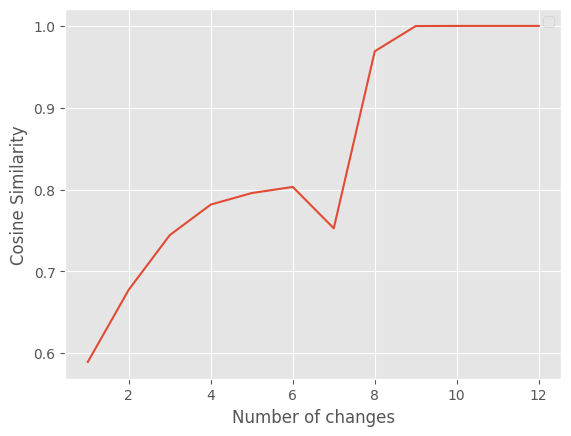

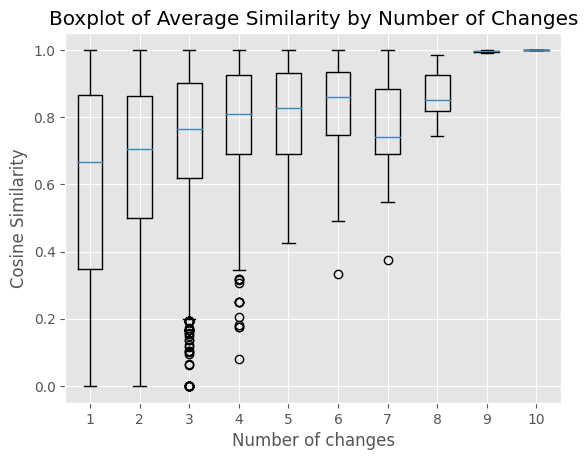

In [ ]:
# group by 'num_changes' and calculate the mean of 'average_similarity' column
summary_stats_change = similarity_df.groupby('num_changes')['cosine_similarity'].agg(['mean', 'count']).reset_index()
summary_stats_change.columns = [ 'num_changes', 'average_similarity', 'num_researchers']

fig, ax = plt.subplots()
ax.plot(summary_stats_change['num_changes'] + 1, summary_stats_change['average_similarity'])
ax.set_xlabel('Number of changes')
ax.set_ylabel('Cosine Similarity')
# ax.legend(loc='best')


# create the boxplot
fig, ax = plt.subplots()
ax.boxplot(summary_stats.groupby('num_changes')['average_similarity'].apply(list))
ax.set_xlabel('Number of changes')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Boxplot of Average Similarity by Number of Changes')

plt.show()

In [ ]:
summary_stats_change

,num_changes,average_similarity,x
0,0,0.589224,149421
1,1,0.677598,25014
2,2,0.744298,4776
3,3,0.781614,1052
4,4,0.795687,238
5,5,0.803132,70
6,6,0.752572,24
7,7,0.968991,9
8,8,0.999867,3
9,9,1.000000,1


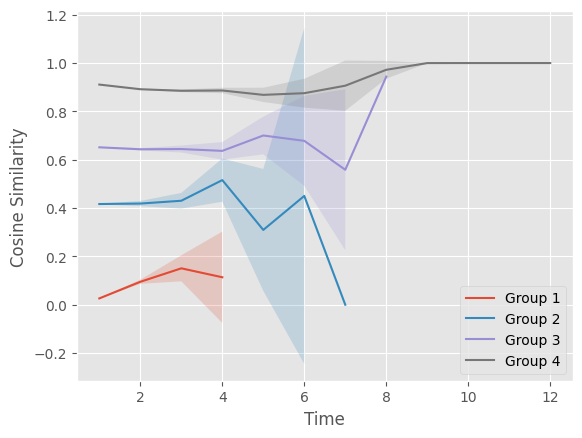

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Define a function to categorize researchers based on their average_similarity
def categorize_researcher(avg_similarity, num_groups=4):
    if avg_similarity <= 0.25:
        return 1
    elif avg_similarity <= 0.5:
        return 2
    elif avg_similarity <= 0.75:
        return 3
    else:
        return 4

# 2. Apply the function to the summary_stats DataFrame to create a new column `group`
summary_stats['group'] = summary_stats['average_similarity'].apply(categorize_researcher)

# 3. Merge the `group` information into the `similarity_df` DataFrame
similarity_df = pd.merge(similarity_df, summary_stats[['researcher_id', 'group']], on='researcher_id')

# 4. Aggregate cosine similarity values for each group and time period
grouped_data = similarity_df.groupby(['group', 'time1'])['cosine_similarity'].agg(['mean', 'std', 'count']).reset_index()

# 5. Calculate the confidence intervals
alpha = 0.95
grouped_data['conf_interval'] = grouped_data.apply(lambda row: stats.t.ppf((1 + alpha) / 2, row['count'] - 1) * row['std'] / np.sqrt(row['count']), axis=1)

# 6. Create a line plot with confidence intervals around the lines for each group over time
fig, ax = plt.subplots()

for group_id, group_data in grouped_data.groupby('group'):
    ax.plot(group_data['time1'], group_data['mean'], label=f'Group {group_id}')
    ax.fill_between(group_data['time1'], group_data['mean'] - group_data['conf_interval'], group_data['mean'] + group_data['conf_interval'], alpha=0.2)

ax.set_xlabel('Time')
ax.set_ylabel('Cosine Similarity')
ax.legend(loc='best')

plt.show()


**It looks like lower similarity groups are associated with less affiliation changes**
- check if researchers can appear in multiple groups
- they should not
- make the same vizualization but for number of changes and see if they agree
- check academic age effects
- check for prestige effects
- make ranking of institutions by the four fields based on the cosine


In [ ]:
similarity_df

In [ ]:
#@title Default title text
from scipy.sparse import csr_matrix, dok_matrix

# Get unique researcher and topic counts
num_researchers = len(np.unique(pubs['au']))
num_topics = len(np.unique(pubs['topic']))

# Initialize the matrices
R = csr_matrix((num_researchers, num_topics), dtype=np.float64)
R_dok = dok_matrix((num_researchers, num_topics), dtype=np.float64)

# Fill the matrices with data from the 'pubs' DataFrame
for idx, row in pubs.iterrows():
    au_idx, topic_idx, pub_count, _ = row
    R[au_idx, topic_idx] = pub_count
    R_dok[au_idx, topic_idx] = pub_count

# Display the matrices
print("R matrix (csr_matrix):")
print(R)

print("\nR_dok matrix (dok_matrix):")
print(R_dok)